# Probabilistic Initiation Set Classifier

## Imports

In [1]:
from sklearn import svm, datasets
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegressionCV as LRCV

import numpy as np
from random import *
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd

# sns.set(color_codes=True)
%matplotlib inline

## Utilities

In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def create_plots(models, titles, X, y, grid):
    """Creates plots of models.
    
        Parameters
        ----------
        models : tuple of models
        titles : tuple of title names
        X : input
        y: class labels
        grid : tuple of grid size 
    """
    
    # Set-up grids for plotting.
    fig, sub = plt.subplots(grid[0], grid[1])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('x-coord')
        ax.set_ylabel('y-coord')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

## Load Data

In [ ]:
X, y = datasets.make_classification(n_samples=1000, n_features=2,
                                    n_informative=2, n_redundant=0)
y[y==0] = -1

## Classification

In [ ]:
def opt_clf(X_, y_):
    '''
    Optimistic classifier that is two-class SVM 
    
    Args:
        X_: Input data
        y_: Input labels
    
    Returns:
        Fitted two-class linear classifier
    '''
    tcsvm = svm.LinearSVC(max_iter=1000)
    
    return tcsvm.fit(X_,y_)

def pes_clf(tcsvm_, X_, y_):
    '''
    Pessimistic classifier that is a one-class SVM
    
    Args:
    
    Returns:
    
    '''
    # Get subset of inputs that are on the (+) side of the optimistic classifier
    y_pred = tcsvm_.predict(X_)
    X_pos, y_pos, X_neg, y_neg = [], [], [], []
    for i, label in enumerate(y_pred):
        if label == 1:
            X_pos.append(X_[i])
            y_pos.append(y_[i])
        else:
            X_neg.append(X_[i])
            y_neg.append(y_[i])
    X_pos, y_pos, X_neg, y_neg = np.array(X_pos), np.array(y_pos), np.array(X_neg), np.array(y_neg)

    # Fit one-class SVM (non-linear) from (+) subset of inputs from two-class SVM
    ocsvm = svm.OneClassSVM(kernel="rbf", nu=0.1, gamma="scale")
    
    return ocsvm.fit(X_pos, y_pos)

In [ ]:
def platt_scale(ocsvm_, X_, train_size, cv_size, outlier=False):
    """
    Uses Platt Scalling to get probability values from one-class SVM
    
    Args:
        clf: OneClassSVM classifier (post-fit on TCSVM (+) data)
        X_data: data that clf was fitted on
        y_labels: labels that cls was fitted on 
    
    Returns:
        
    """
    
    # 1. Get SVM predictions
    y_SVM_pred = ocsvm_.predict(X_)
    if outlier:
        y_SVM_pred = y_SVM_pred * -1
    
    # 2. Split the data and SVM labels
    X_train, X_test, y_train, y_test = train_test_split(X_, y_SVM_pred, train_size=train_size)

    # 3. Train using logistic regression layer with cross validation 
    lr = LRCV(cv=cv_size)
    lr.fit(X_train, y_train)

    # 4. Return prediction probabilities on test data    
    return lr.predict_proba(X_test)

## Probabilities

In [ ]:
# Call classifiers
tcsvm = opt_clf(X, y)
ocsvm = pes_clf(tcsvm, X, y)

# Estimations for optimistic classifier
print("Optimistic Classifier")
print("=====================")
print("(1a) Pr(pos sample | (+) side of TCSVM) = Pr(neg sample | (-) side of TCSVM) = {}".format(tcsvm.score(X,y)))
print("(1b) Pr(pos sample | (-) side of TCSVM) = Pr(neg sample | (+) side of TCSVM) = {}".format(1-tcsvm.score(X,y)))
print()

# Estimations for pessimistic classifier
prob_inlier = platt_scale(ocsvm, X, 0.90, 5)
prob_outlier = platt_scale(ocsvm, X, 0.90, 5, outlier=True)

print("Pessimistic Classifier")
print("======================")
print("(2a) Pr(pos sample | inside OCSVM) = {}".format(np.average(prob_inlier[:,1])))
print("(2b) Pr(neg sample | inside OCSVM) = {}".format(np.average(prob_inlier[:,0])))
print("(2c) Pr(pos sample | outside OCSVM) = {}".format(np.average(prob_outlier[:,1])))
print("(2d) Pr(neg sample | outside OCSVM) = {}".format(np.average(prob_outlier[:,0])))

print("Difference")
print("==========")
print("|1a - 2a| = {}".format(abs(tcsvm.score(X,y) - np.average(prob_inlier[:,1]))))

## Plotting

In [ ]:
# Plot two classifiers
models = (tcsvm, ocsvm)
titles = ('LinearSVC (linear kernel)', 'OneClassSVM (rbf kernel)')
create_plots(models, titles, X, y, grid=(2,1))

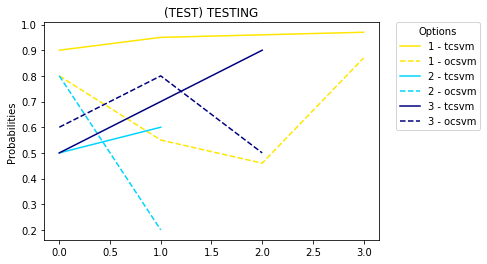

In [2]:
# Probability plots
all_tcsvm_prob = {}
all_tcsvm_prob[1] = [0.9, 0.95, 0.96, 0.97]
all_tcsvm_prob[2] = [0.5, 0.6]
all_tcsvm_prob[3] = [0.5, 0.7, 0.9]

all_ocsvm_prob = {}
all_ocsvm_prob[1] = [0.8, 0.55, 0.46, 0.87]
all_ocsvm_prob[2] = [0.8, 0.2]
all_ocsvm_prob[3] = [0.6, 0.8, 0.5]
# ocsvm_prob = [0.6, 0.5, 0.7, 0.8]
# diff_prob = [0.3, 0.45, 0.26, 0.17]

cmap = plt.get_cmap('jet_r')
N = len(all_tcsvm_prob)

for idx, tcsvm_prob in all_tcsvm_prob.items():
    color = cmap(float(idx)/N)

    plt.plot(tcsvm_prob, c=color, label="{} - tcsvm".format(idx))
    plt.plot(all_ocsvm_prob[idx], c=color, label="{} - ocsvm".format(idx), linestyle='--')    

# for idx, option_prob in all_ocsvm_prob.items():
#     plt.plot(option_prob, label="{} - ocsvm".format(idx), linestyle='--')
    

test1 = "(TEST)"
test2 = "TESTING"

plt.title("{} {}".format(test1, test2))
plt.ylabel("Probabilities")
plt.legend(title="Options", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()



In [ ]:
tcsvm_prob[0] = [0.9, 0.95, 0.96, 0.97, 0.6]
tcsvm_prob

In [ ]:
test = []
if not test:
    print("empty")
# [row[0] for row in test]